In [1]:
# HF token prelude – load from common macOS locations and set env for HF
import os, pathlib

def load_hf_token():
    candidates = [
        pathlib.Path("~/.cache/huggingface/token").expanduser(),
        pathlib.Path("~/Library/Application Support/huggingface/token").expanduser(),
        pathlib.Path("~/.huggingface/token").expanduser(),
    ]
    for p in candidates:
        if p.exists():
            tok = p.read_text().strip()
            if tok.startswith("hf_"):
                return tok
    # Fallback to env if user already exported it
    return os.environ.get("HF_TOKEN")

HF_TOKEN = load_hf_token()
if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN  # make visible to transformers/hub
    print("✅ HF token loaded (length:", len(HF_TOKEN), ")")
else:
    print("⚠️ No HF token found. Set os.environ['HF_TOKEN'] = 'hf_...'.")

✅ HF token loaded (length: 37 )


In [2]:
# --- SRB import prelude: point to the correct repo and reload the module ---

import sys, os, importlib, inspect

# 1) Point to the repo that actually contains your updated metrics.py
repo_root = "/Users/joeystafford/repos/semantic-resonance-budget-falsification"

# Ensure it’s at the *front* of sys.path so it wins over any other srb installs/paths
if repo_root in sys.path:
    sys.path.remove(repo_root)
sys.path.insert(0, repo_root)

# 2) Purge any previously loaded 'srb' to avoid stale modules
for name in list(sys.modules.keys()):
    if name == "srb" or name.startswith("srb."):
        del sys.modules[name]

# 3) Import and reload to be extra sure we’re using the right file
import srb.metrics as sm
print("Using metrics module at:", sm.__file__)
importlib.reload(sm)

# 4) Sanity: list the exported helpers you need
wanted = ["chunk_text_windows", "pairwise", "cosine_text_similarity", "ncd_similarity",
          "levenshtein_similarity_tokens", "coherence_composite", "repetition_ratio"]
available = [n for n, o in sm.__dict__.items() if callable(o) and n in wanted]
print("Available functions:", available)

# 5) Finally import the fresh symbols into the notebook namespace
from srb.metrics import (
    chunk_text_windows, pairwise,
    cosine_text_similarity, ncd_similarity,
    levenshtein_similarity_tokens, coherence_composite, repetition_ratio
)

Using metrics module at: /Users/joeystafford/repos/semantic-resonance-budget-falsification/srb/metrics.py
Available functions: ['cosine_text_similarity', 'ncd_similarity', 'levenshtein_similarity_tokens', 'chunk_text_windows', 'pairwise', 'repetition_ratio', 'coherence_composite']


ℹ️ tokenizer/model not found — loading here.
→ Trying model: meta-llama/Llama-3-8B-Instruct
✗ Could not load meta-llama/Llama-3-8B-Instruct: meta-llama/Llama-3-8B-Instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
→ Trying model: mistralai/Mistral-7B-Instruct-v0.3
✗ Could not load mistralai/Mistral-7B-Instruct-v0.3: 
 requires the protobuf library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

→ Trying model: Qwen/Qwen2.5-7B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Loaded: Qwen/Qwen2.5-7B-Instruct

[Coherent (A)] windows=7
 mean cosine=0.912, 1−NCD=0.267, Lev=0.006, comp=0.588, rep(agg)=0.002, xrep(agg)=0.007

[Topic-Roulette (B)] windows=8
 mean cosine=0.870, 1−NCD=0.288, Lev=0.024, comp=0.570, rep(agg)=0.014, xrep(agg)=0.041


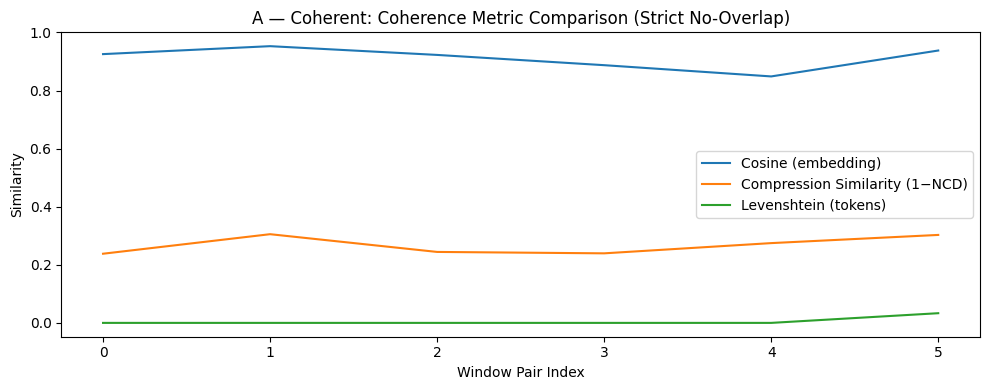

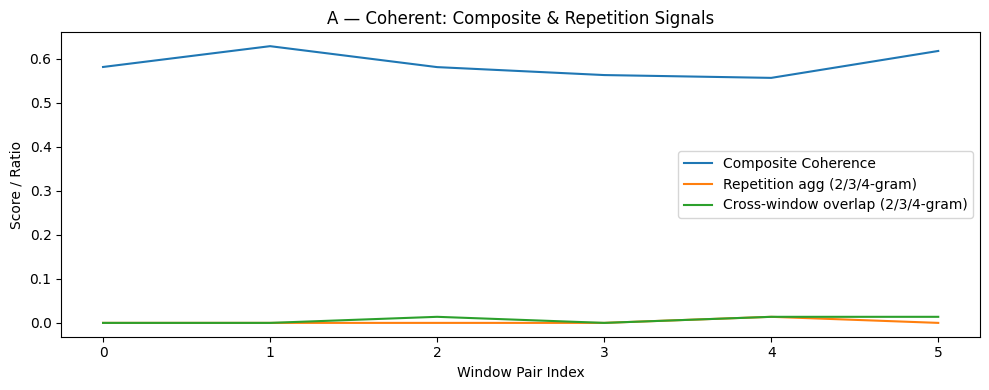

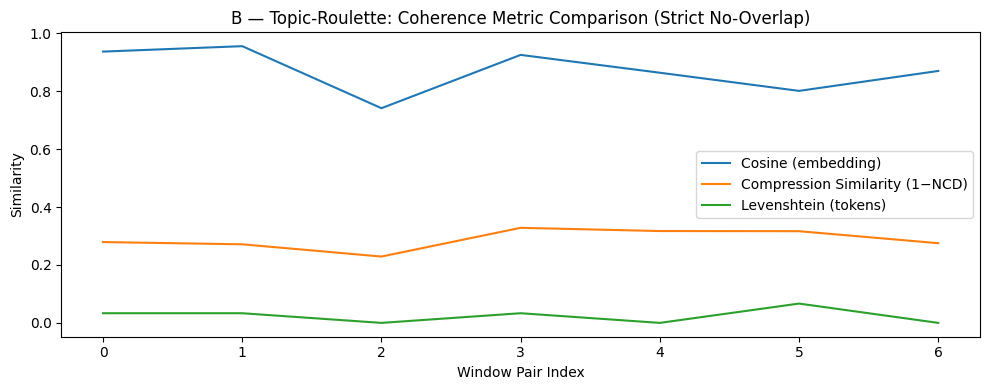

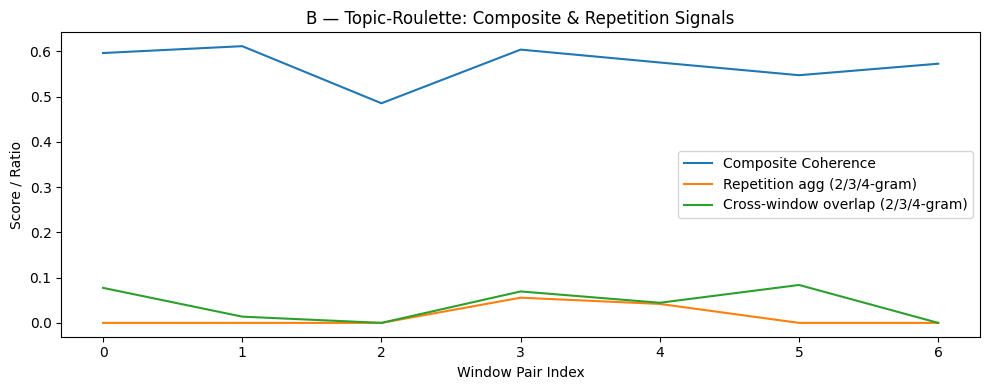


=== Window-size sweep (A / coherent) ===

[W=30] windows=7
 mean cosine=0.912, 1−NCD=0.267, Lev=0.006, comp=0.588, rep(agg)=0.002, xrep(agg)=0.007

[W=40] windows=5
 mean cosine=0.902, 1−NCD=0.244, Lev=0.013, comp=0.571, rep(agg)=0.003, xrep(agg)=0.010

[W=50] windows=4
 mean cosine=0.925, 1−NCD=0.214, Lev=0.020, comp=0.567, rep(agg)=0.003, xrep(agg)=0.014

=== Compression sweep (A / coherent) ===
gzip: mean 1−NCD=0.267, corr(comp,ncd)=0.749
 bz2: mean 1−NCD=0.340, corr(comp,ncd)=0.835
lzma: mean 1−NCD=0.456, corr(comp,ncd)=0.805


In [3]:
# === Cell 3 — Pro: SRB A/B with Strict No-Overlap, N-gram controls, sweeps, and export ===
# Works even if Cell 1/2 weren't run (has safe fallbacks).

import os, re, time, json, numpy as np, torch, matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# -----------------------------
# 0) Ensure tokenizer/model exist (fallback loader if missing)
# -----------------------------
try:
    tokenizer, model
    print("✅ Using existing tokenizer/model from earlier cells.")
except NameError:
    print("ℹ️ tokenizer/model not found — loading here.")
    from transformers import AutoModelForCausalLM, AutoTokenizer

    HF_TOKEN = os.environ.get("HF_TOKEN")
    token_kw = {"token": HF_TOKEN} if HF_TOKEN else {}

    PREFERRED_MODELS = [
        "meta-llama/Llama-3-8B-Instruct",      # gated
        "mistralai/Mistral-7B-Instruct-v0.3",  # public
        "Qwen/Qwen2.5-7B-Instruct",            # public
        "distilGPT2",                          # tiny fallback
    ]

    def try_load(model_name: str):
        print(f"→ Trying model: {model_name}")
        tok = AutoTokenizer.from_pretrained(model_name, **token_kw)
        mdl = AutoModelForCausalLM.from_pretrained(
            model_name, device_map="auto", torch_dtype="auto", **token_kw
        )
        if tok.pad_token is None:
            tok.pad_token = tok.eos_token
        if getattr(mdl.config, "pad_token_id", None) is None:
            mdl.config.pad_token_id = tok.pad_token_id
        mdl.eval()
        return tok, mdl

    tokenizer = model = None
    last_err = None
    for name in PREFERRED_MODELS:
        try:
            tokenizer, model = try_load(name)
            print(f"✅ Loaded: {name}")
            break
        except Exception as e:
            last_err = e
            print(f"✗ Could not load {name}: {e}")
    if model is None:
        raise RuntimeError("Failed to load any model. Ensure HF_TOKEN is set & license accepted.\n"
                           f"Last error: {last_err}")

# -----------------------------
# 1) Fast embedding (define if missing)
# -----------------------------
try:
    batch_embed
    print("✅ Using existing batch_embed().")
except NameError:
    def batch_embed(texts):
        """Mean-pooled last hidden states (cast to float32 for NumPy)."""
        with torch.no_grad():
            toks = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
            out  = model(**toks, output_hidden_states=True)
            last = out.hidden_states[-1].to(torch.float32)   # [B,S,H]
            vecs = last.mean(dim=1).detach().cpu().numpy()   # [B,H]
            return vecs

def cosine_vec(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

# -----------------------------
# 2) N-gram utilities (2/3/4-gram) — within-window repetition & cross-window overlap
# -----------------------------
_word_splitter = re.compile(r"\s+")

def _tokenize_words(text: str):
    return [w for w in _word_splitter.split(text.strip().lower()) if w]

def _ngrams(tokens, n: int):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)] if len(tokens) >= n else []

def repetition_ratio_ngram(text: str, n: int) -> float:
    """Within-window repetition for n-grams: (repeats beyond first)/total n-grams."""
    toks = _tokenize_words(text)
    grams = _ngrams(toks, n)
    if not grams: return 0.0
    c = Counter(grams)
    repeats = sum(cnt - 1 for cnt in c.values() if cnt > 1)
    return float(repeats) / float(len(grams))

def cross_overlap_ratio(prev_text: str, curr_text: str, n: int) -> float:
    """Cross-window overlap: |grams(prev) ∩ grams(curr)| / max(|prev|, |curr|)."""
    p = _tokenize_words(prev_text); c = _tokenize_words(curr_text)
    pN, cN = set(_ngrams(p, n)), set(_ngrams(c, n))
    if not pN or not cN: return 0.0
    return len(pN & cN) / float(max(len(pN), len(cN)))

def repetition_aggregate(text: str, weights=(0.4, 0.4, 0.2)):
    """Weighted 2/3/4-gram repetition (defaults favor 2 & 3)."""
    w2, w3, w4 = weights
    return (w2 * repetition_ratio_ngram(text, 2)
          + w3 * repetition_ratio_ngram(text, 3)
          + w4 * repetition_ratio_ngram(text, 4))

def overlap_aggregate(prev_text: str, curr_text: str, weights=(0.4, 0.4, 0.2)):
    """Weighted 2/3/4-gram cross-window overlap."""
    w2, w3, w4 = weights
    return (w2 * cross_overlap_ratio(prev_text, curr_text, 2)
          + w3 * cross_overlap_ratio(prev_text, curr_text, 3)
          + w4 * cross_overlap_ratio(prev_text, curr_text, 4))

# -----------------------------
# 3) Chunk text into STRICT NO-OVERLAP windows
# -----------------------------
def chunk_text_windows_strict(text: str, window_words: int):
    words = _tokenize_words(text)
    out = []
    for i in range(0, len(words), window_words):
        w = words[i:i+window_words]
        if len(w) == window_words:
            out.append(" ".join(w))
    return out

# -----------------------------
# 4) Generators (Coherent & Topic-Roulette)
# -----------------------------
def _ensure_pad():
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
    if getattr(model.config, "pad_token_id", None) is None:
        model.config.pad_token_id = tokenizer.pad_token_id

def generate_text(prompt, max_new=240, temperature=0.9, top_p=0.95):
    _ensure_pad()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new,
            do_sample=True, temperature=temperature, top_p=top_p,
            return_dict_in_generate=True
        )
    return tokenizer.decode(out.sequences[0], skip_special_tokens=True)

def generate_topic_roulette(prompts, max_new_each=100, temperature=0.95, top_p=0.92):
    _ensure_pad()
    segments = []
    for p in prompts:
        inputs = tokenizer(p, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out = model.generate(
                **inputs,
                max_new_tokens=max_new_each,
                do_sample=True, temperature=temperature, top_p=top_p,
                return_dict_in_generate=True
            )
        segments.append(tokenizer.decode(out.sequences[0], skip_special_tokens=True))
    return "\n".join(segments)

# -----------------------------
# 5) Analyzer (single run)
# -----------------------------
from srb.metrics import ncd_similarity, levenshtein_similarity_tokens  # re-use your utils

def analyze_series(generated_text, window_words=30, stride_words=None, compression_method="gzip"):
    if stride_words is None: stride_words = window_words   # STRICT NO-OVERLAP
    assert stride_words == window_words, "This analyzer uses strict no-overlap by design."

    windows = chunk_text_windows_strict(generated_text, window_words=window_words)
    if len(windows) < 2:
        return None

    embs = batch_embed(windows)
    cos_vals, ncd_vals, lev_vals, comp_vals, rep_vals, xrep_vals = [], [], [], [], [], []

    for i in range(len(windows) - 1):
        prev_w, curr_w = windows[i], windows[i+1]

        cos  = cosine_vec(embs[i], embs[i+1])
        ncd  = ncd_similarity(prev_w, curr_w, method=compression_method)
        lev  = levenshtein_similarity_tokens(prev_w, curr_w)
        rep  = repetition_aggregate(curr_w)            # within-window (2/3/4)
        xrep = overlap_aggregate(prev_w, curr_w)       # cross-window (2/3/4)

        base = 0.5*cos + 0.5*ncd
        comp = max(0.0, base * (1.0 - 0.35*rep - 0.25*xrep))

        cos_vals.append(cos); ncd_vals.append(ncd); lev_vals.append(lev)
        rep_vals.append(rep); xrep_vals.append(xrep); comp_vals.append(comp)

    return {
        "windows": windows,
        "cos": np.array(cos_vals), "ncd": np.array(ncd_vals), "lev": np.array(lev_vals),
        "rep": np.array(rep_vals), "xrep": np.array(xrep_vals), "comp": np.array(comp_vals),
    }

def describe(label, res):
    if res is None:
        print(f"{label}: not enough windows"); 
        return
    print(f"\n[{label}] windows={len(res['cos'])+1}")
    print(f" mean cosine={res['cos'].mean():.3f}, 1−NCD={res['ncd'].mean():.3f}, "
          f"Lev={res['lev'].mean():.3f}, comp={res['comp'].mean():.3f}, "
          f"rep(agg)={res['rep'].mean():.3f}, xrep(agg)={res['xrep'].mean():.3f}")

# -----------------------------
# 6) Run A/B: Coherent vs Topic-Roulette
# -----------------------------
PROMPT_COHERENT = (
    "Explain quantum entanglement to a curious high-school student using analogies and avoid repeating phrases."
)
ROULETTE_PROMPTS = [
    "Describe the history of the Silk Road in three paragraphs.",
    "Write a short recipe for a vegan ramen broth.",
    "Summarize pros and cons of nuclear fusion research in a neutral tone.",
]

text_A = generate_text(PROMPT_COHERENT, max_new=260, temperature=0.9, top_p=0.95)
text_B = generate_topic_roulette(ROULETTE_PROMPTS, max_new_each=100, temperature=0.95, top_p=0.92)

W = 30  # window size (strict no-overlap)
res_A = analyze_series(text_A, window_words=W, compression_method="gzip")
res_B = analyze_series(text_B, window_words=W, compression_method="gzip")

describe("Coherent (A)", res_A)
describe("Topic-Roulette (B)", res_B)

# -----------------------------
# 7) Plot trajectories (A & B)
# -----------------------------
def plot_series(res, title_prefix):
    if res is None: return
    x = np.arange(len(res["cos"]))
    plt.figure(figsize=(10,4))
    plt.plot(x, res["cos"], label="Cosine (embedding)")
    plt.plot(x, res["ncd"], label="Compression Similarity (1−NCD)")
    plt.plot(x, res["lev"], label="Levenshtein (tokens)")
    plt.title(f"{title_prefix}: Coherence Metric Comparison (Strict No-Overlap)")
    plt.xlabel("Window Pair Index"); plt.ylabel("Similarity")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(x, res["comp"], label="Composite Coherence")
    plt.plot(x, res["rep"],  label="Repetition agg (2/3/4-gram)")
    plt.plot(x, res["xrep"], label="Cross-window overlap (2/3/4-gram)")
    plt.title(f"{title_prefix}: Composite & Repetition Signals")
    plt.xlabel("Window Pair Index"); plt.ylabel("Score / Ratio")
    plt.legend(); plt.tight_layout(); plt.show()

plot_series(res_A, "A — Coherent")
plot_series(res_B, "B — Topic-Roulette")

# -----------------------------
# 8) Sensitivity sweeps
# -----------------------------
print("\n=== Window-size sweep (A / coherent) ===")
for Wtest in (30, 40, 50):
    r = analyze_series(text_A, window_words=Wtest, compression_method="gzip")
    describe(f"W={Wtest}", r)

print("\n=== Compression sweep (A / coherent) ===")
for method in ("gzip", "bz2", "lzma"):  # lzma slower, often stronger structure detector
    r = analyze_series(text_A, window_words=30, compression_method=method)
    if r is None: continue
    corr = float(np.corrcoef(r["comp"], r["ncd"])[0,1]) if len(r["comp"])>1 else np.nan
    print(f"{method:>4}: mean 1−NCD={r['ncd'].mean():.3f}, corr(comp,ncd)={corr:.3f}")

# -----------------------------
# 9) Optional export of runs (CSV + metadata)
# -----------------------------
def export_run(label, text, res, base_dir="srb_results"):
    ts = time.strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_dir, f"{ts}_{label.replace(' ','_').lower()}")
    os.makedirs(run_dir, exist_ok=True)

    # save raw text
    with open(os.path.join(run_dir, "generated.txt"), "w", encoding="utf-8") as f:
        f.write(text)

    # save curves
    df = pd.DataFrame({
        "cosine": res["cos"], "ncd": res["ncd"], "lev": res["lev"],
        "rep": res["rep"], "xrep": res["xrep"], "comp": res["comp"],
    })
    df.to_csv(os.path.join(run_dir, "curves.csv"), index=False)

    # meta
    meta = {
        "window_words": W,
        "strict_no_overlap": True,
        "model_name": getattr(model.config, "name_or_path", "unknown"),
        "tokenizer_name": getattr(tokenizer, "name_or_path", "unknown"),
    }
    with open(os.path.join(run_dir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)
    print(f"📁 Exported → {run_dir}")
    return run_dir

# Toggle these if you want files saved:
# export_run("A_coherent_no_overlap", text_A, res_A)
# export_run("B_topic_roulette_no_overlap", text_B, res_B)

In [ ]:
# --- SRB Coherence Metric Comparison across 3 prompt behaviors ---

import numpy as np
import matplotlib.pyplot as plt
from srb.metrics import (
    chunk_text_windows, pairwise,
    cosine_text_similarity, ncd_similarity, levenshtein_similarity_tokens,
    coherence_composite, repetition_ratio
)
import torch

def evaluate_prompt(prompt: str, label: str,
                    max_new_tokens: int = 220,
                    temperature: float = 0.9,
                    window_words: int = 30,
                    step_words:   int = 15):
    """Generate text, window it, compute metrics, plot curves, and print stats."""
    print(f"\n========== [{label}] ==========")
    print("Prompt:", prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=0.95,
            return_dict_in_generate=True
        )
    text = tokenizer.decode(gen.sequences[0], skip_special_tokens=True)

    windows = chunk_text_windows(text, window_words=window_words, step_words=step_words)
    if len(windows) < 2:
        print("Not enough text for window comparisons. Try increasing max_new_tokens or reducing window size.")
        print("\n--- Generated Text ---\n", text)
        return None

    cos_vals, ncd_vals, lev_vals, comp_vals, rep_vals = [], [], [], [], []
    for prev_w, curr_w in pairwise(windows):
        cos_vals.append(cosine_text_similarity(prev_w, curr_w, embed_fn))
        ncd_vals.append(ncd_similarity(prev_w, curr_w))
        lev_vals.append(levenshtein_similarity_tokens(prev_w, curr_w))
        comp_vals.append(coherence_composite(prev_w, curr_w, embed_fn))
        rep_vals.append(repetition_ratio(curr_w))

    cos_vals = np.array(cos_vals, dtype=float)
    ncd_vals = np.array(ncd_vals, dtype=float)
    lev_vals = np.array(lev_vals, dtype=float)
    comp_vals= np.array(comp_vals, dtype=float)
    rep_vals = np.array(rep_vals, dtype=float)

    # Plot 1: core metrics
    plt.figure(figsize=(10, 4))
    plt.plot(cos_vals, label="Cosine (embedding)")
    plt.plot(ncd_vals, label="Compression Similarity (1 - NCD)")
    plt.plot(lev_vals, label="Levenshtein Similarity (tokens)")
    plt.title(f"[{label}] Coherence Metric Comparison")
    plt.xlabel("Window Pair Index")
    plt.ylabel("Similarity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: composite + repetition
    plt.figure(figsize=(10, 4))
    plt.plot(comp_vals, label="Composite Coherence")
    plt.plot(rep_vals, label="Repetition Ratio")
    plt.title(f"[{label}] Composite / Repetition")
    plt.xlabel("Window Pair Index")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Correlations
    def safe_corr(a, b):
        if len(a) < 2 or np.all(a == a[0]) or np.all(b == b[0]):
            return np.nan
        return float(np.corrcoef(a, b)[0, 1])

    print("=== Pearson Correlations ===")
    print(f"cos  vs comp  : {safe_corr(cos_vals, comp_vals): .3f}")
    print(f"cos  vs ncd   : {safe_corr(cos_vals, ncd_vals): .3f}")
    print(f"cos  vs lev   : {safe_corr(cos_vals, lev_vals): .3f}")
    print(f"comp vs ncd   : {safe_corr(comp_vals, ncd_vals): .3f}")
    print(f"comp vs lev   : {safe_corr(comp_vals, lev_vals): .3f}")
    print(f"ncd  vs lev   : {safe_corr(ncd_vals, lev_vals): .3f}")
    print(f"rep  vs cos   : {safe_corr(rep_vals, cos_vals): .3f}")
    print(f"rep  vs comp  : {safe_corr(rep_vals, comp_vals): .3f}")
    print(f"rep  vs ncd   : {safe_corr(rep_vals, ncd_vals): .3f}")
    print(f"rep  vs lev   : {safe_corr(rep_vals, lev_vals): .3f}")

    # Summary
    print("\nSummary:")
    print(f"- Windows: {len(windows)} (size={window_words}, step={step_words})")
    print(f"- Mean cosine:     {cos_vals.mean():.3f}")
    print(f"- Mean 1-NCD:      {ncd_vals.mean():.3f}")
    print(f"- Mean Lev(tokens):{lev_vals.mean():.3f}")
    print(f"- Mean composite:  {comp_vals.mean():.3f}")
    print(f"- Mean repetition: {rep_vals.mean():.3f}")

    # Return for optional downstream aggregation
    return {
        "label": label,
        "text": text,
        "cos": cos_vals, "ncd": ncd_vals, "lev": lev_vals, "comp": comp_vals, "rep": rep_vals
    }

# --- Run three behavior regimes ---

prompts = [
    ("Repetition", 
     "Repeat the following sentence exactly, thirty times in a row, with periods between each: "
     "'Order emerges from careful attention.'"),
    ("Creative/Bilingual", 
     "Write a short poem alternating lines in English and Japanese (romaji ok). "
     "Avoid repeating phrases and favor metaphor."),
    ("Long-form Reasoning", 
     "Answer the following three questions in sequence with clear transitions: "
     "1) What is quantum entanglement? "
     "2) Why does it not enable faster-than-light communication? "
     "3) Give a real-world analogy that avoids repetition.")
]

results = []
for label, prompt in prompts:
    res = evaluate_prompt(prompt, label,
                          max_new_tokens=260,
                          temperature=0.9,
                          window_words=30,
                          step_words=15)
    if res is not None:
        results.append(res)

print("\nCompleted all prompt evaluations.")

In [ ]:
# --- Aggregated correlations across prompts (with partials controlling for repetition) ---

import numpy as np
import pandas as pd

def safe_corr(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if len(a) < 2 or np.allclose(a, a[0]) or np.allclose(b, b[0]):
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def residualize(y, z):
    """
    Remove linear effect of z from y: y_res = y - (alpha + beta*z).
    Adds a bias term for intercept.
    """
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    if len(y) != len(z) or len(y) < 2 or np.allclose(z, z[0]):
        return y  # fallback
    X = np.column_stack([np.ones_like(z), z])
    # Least squares fit
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    return y - y_hat

def corr_row(label, cos, ncd, lev, comp, rep):
    # Raw Pearson
    row = {
        "prompt": label,
        "r(cos,comp)": safe_corr(cos, comp),
        "r(cos,ncd)":  safe_corr(cos, ncd),
        "r(cos,lev)":  safe_corr(cos, lev),
        "r(comp,ncd)": safe_corr(comp, ncd),
        "r(comp,lev)": safe_corr(comp, lev),
        "r(ncd,lev)":  safe_corr(ncd, lev),
        "r(rep,cos)":  safe_corr(rep, cos),
        "r(rep,comp)": safe_corr(rep, comp),
        "r(rep,ncd)":  safe_corr(rep, ncd),
        "r(rep,lev)":  safe_corr(rep, lev),
        "mean_cos":    np.nanmean(cos),
        "mean_comp":   np.nanmean(comp),
        "mean_ncd":    np.nanmean(ncd),
        "mean_lev":    np.nanmean(lev),
        "mean_rep":    np.nanmean(rep),
        "n_pairs":     len(cos),
    }

    # Partial correlations controlling for repetition (rep)
    cos_res  = residualize(cos, rep)
    comp_res = residualize(comp, rep)
    ncd_res  = residualize(ncd, rep)
    lev_res  = residualize(lev, rep)

    row.update({
        "partial r(cos,comp)|rep": safe_corr(cos_res, comp_res),
        "partial r(cos,ncd)|rep":  safe_corr(cos_res, ncd_res),
        "partial r(cos,lev)|rep":  safe_corr(cos_res, lev_res),
        "partial r(comp,ncd)|rep": safe_corr(comp_res, ncd_res),
        "partial r(comp,lev)|rep": safe_corr(comp_res, lev_res),
        "partial r(ncd,lev)|rep":  safe_corr(ncd_res, lev_res),
    })
    return row

# Build table per prompt
rows = []
for res in results:
    rows.append(
        corr_row(
            res["label"],
            res["cos"], res["ncd"], res["lev"], res["comp"], res["rep"]
        )
    )

df = pd.DataFrame(rows)

# Add an overall row (concatenate all pairs from all prompts)
all_cos  = np.concatenate([r["cos"] for r in results if len(r["cos"]) > 0], axis=0)
all_ncd  = np.concatenate([r["ncd"] for r in results if len(r["ncd"]) > 0], axis=0)
all_lev  = np.concatenate([r["lev"] for r in results if len(r["lev"]) > 0], axis=0)
all_comp = np.concatenate([r["comp"] for r in results if len(r["comp"]) > 0], axis=0)
all_rep  = np.concatenate([r["rep"] for r in results if len(r["rep"]) > 0], axis=0)

overall = corr_row("ALL", all_cos, all_ncd, all_lev, all_comp, all_rep)
df = pd.concat([df, pd.DataFrame([overall])], ignore_index=True)

# Display a compact view
cols_order = [
    "prompt", "n_pairs",
    "r(cos,comp)", "r(cos,ncd)", "r(cos,lev)",
    "r(rep,cos)", "r(rep,comp)",
    "partial r(cos,comp)|rep", "partial r(cos,ncd)|rep", "partial r(cos,lev)|rep",
    "mean_cos", "mean_comp", "mean_ncd", "mean_lev", "mean_rep"
]
display(df[cols_order].round(3))

print("\nInterpretation tips:")
print("- If r(rep,cos) is strongly positive but partial r(cos,comp)|rep stays moderate/strong, cosine inflation from repetition is being corrected by the composite.")
print("- If r(cos,ncd) and r(cos,lev) drop a lot after partialling out rep, cosine was overvaluing loops.")
print("- In the Creative/Bilingual prompt, expect lower raw r(cos,*) but healthier partials if the text is coherent without repetition.")

In [ ]:
# --- Export SRB Experiment Results (Cell 4) ---

import pandas as pd
import numpy as np
import os, json, time

timestamp = time.strftime("%Y%m%d_%H%M%S")
exp_dir = f"srb_results/{timestamp}"
os.makedirs(exp_dir, exist_ok=True)

print(f"📁 Saving results to: {exp_dir}")

# --- Save generated text + metric curves ---
for res in results:
    label = res["label"].replace(" ", "_").lower()
    subdir = f"{exp_dir}/{label}"
    os.makedirs(subdir, exist_ok=True)

    # Save generated text
    with open(f"{subdir}/generated.txt", "w", encoding="utf-8") as f:
        f.write(res["text"])

    # Save metric curves
    df_curves = pd.DataFrame({
        "cosine": res["cos"],
        "compression_sim": res["ncd"],
        "levenshtein_tok": res["lev"],
        "composite": res["comp"],
        "repetition": res["rep"]
    })
    df_curves.to_csv(f"{subdir}/curves.csv", index=False)

# --- Save summary table (all prompts) ---
df.to_csv(f"{exp_dir}/summary_table.csv", index=False)

# --- Save prompts used ---
prompt_list = {r["label"]: p for (r, (_, p)) in zip(results, prompts)}
with open(f"{exp_dir}/prompts.json", "w", encoding="utf-8") as f:
    json.dump(prompt_list, f, indent=2)

# --- Save experiment metadata for reproducibility ---
meta = {
    "timestamp": timestamp,
    "model": model_name,
    "window_words": WINDOW_WORDS,
    "step_words": STEP_WORDS,
    "max_new_tokens": 220,
    "temperature": 0.9,
    "top_p": 0.95
}
with open(f"{exp_dir}/metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Export complete!")

# Show tree
print("\n📦 Files created:")
for root, dirs, files in os.walk(exp_dir):
    level = root.replace(exp_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for fn in files:
        print(f"{indent}  - {fn}")

In [ ]:
# --- Semantic vs Noise Trajectory (Coherent vs Topic-Roulette) ---

import numpy as np, torch, matplotlib.pyplot as plt, random, os
from datetime import datetime

# Reuse your tokenizer/model + helpers already loaded:
# - tokenizer, model, chunk_text_windows, levenshtein_similarity_tokens, repetition_ratio
# - batch_embed(texts) and cosine_vec(a,b) from earlier cell
# - ncd_similarity(prev, curr, method="gzip") available in srb.metrics

from srb.metrics import ncd_similarity

# ---------- Prompts ----------
PROMPT_COHERENT = (
    "Explain quantum entanglement to a curious high-school student using analogies "
    "and avoid repeating phrases."
)

TOPICS = [
    "ancient pottery", "orbital mechanics", "sourdough starters", "volcanoes",
    "medieval trade routes", "neural networks", "whale songs", "gardening in shade",
    "string instruments", "lighthouses", "honeybee swarms", "bicycle maintenance"
]
PROMPT_TOPIC_ROULETTE = (
    "Write 10 sentences. Each sentence must address a RANDOMLY chosen topic from this list, "
    "with no attempt to connect them: " + ", ".join(TOPICS) + ". "
    "Do not repeat topics; make each sentence self-contained and switch topics every sentence. "
    "Avoid repeating phrases."
)

# ---------- Generation helper ----------
def generate_text(prompt, max_new=180, temperature=0.9, top_p=0.95):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    if getattr(model.config, "pad_token_id", None) is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            return_dict_in_generate=True
        )
    return tokenizer.decode(out.sequences[0], skip_special_tokens=True)

# ---------- Metric over windows ----------
WINDOW_WORDS, STEP_WORDS = 30, 15
COMP_METHOD = "gzip"

def metric_series(text):
    windows = chunk_text_windows(text, window_words=WINDOW_WORDS, step_words=STEP_WORDS)
    if len(windows) < 2:
        return dict(cos=[], ncd=[], comp=[], win_count=len(windows), windows=windows)

    # batch-embed all windows once (handles bfloat16 in your helper)
    embs = batch_embed(windows)

    cos, ncd, comp = [], [], []
    for i in range(len(windows) - 1):
        prev_w, curr_w = windows[i], windows[i+1]
        # cosine
        c = cosine_vec(embs[i], embs[i+1]); cos.append(c)
        # compression similarity
        s = ncd_similarity(prev_w, curr_w, method=COMP_METHOD); ncd.append(s)
        # simple composite: blend cosine+NCD, penalize repetition lightly
        rep = 0.5 * (repetition_ratio(prev_w) + repetition_ratio(curr_w))
        base = 0.5 * c + 0.5 * s
        comp.append(base * (1.0 - 0.3 * rep))
    return dict(cos=np.array(cos), ncd=np.array(ncd), comp=np.array(comp),
                win_count=len(windows), windows=windows)

# ---------- Run both conditions ----------
text_coherent = generate_text(PROMPT_COHERENT, max_new=180)
text_roulette = generate_text(PROMPT_TOPIC_ROULETTE, max_new=180)

series_coh = metric_series(text_coherent)
series_noise = metric_series(text_roulette)

# ---------- Plot: Cosine ----------
plt.figure(figsize=(9,3.4))
plt.plot(series_coh["cos"], label="Cosine — Coherent")
plt.plot(series_noise["cos"], label="Cosine — Topic-Roulette")
plt.title("Cosine Coherence Trajectories")
plt.xlabel("Window Pair Index"); plt.ylabel("Similarity")
plt.legend(); plt.tight_layout()
plt.show()

# ---------- Plot: 1 − NCD ----------
plt.figure(figsize=(9,3.4))
plt.plot(series_coh["ncd"], label="1−NCD — Coherent")
plt.plot(series_noise["ncd"], label="1−NCD — Topic-Roulette")
plt.title("Compression Similarity Trajectories (1 − NCD, gzip)")
plt.xlabel("Window Pair Index"); plt.ylabel("Similarity")
plt.legend(); plt.tight_layout()
plt.show()

# ---------- Plot: Composite ----------
plt.figure(figsize=(9,3.4))
plt.plot(series_coh["comp"], label="Composite — Coherent")
plt.plot(series_noise["comp"], label="Composite — Topic-Roulette")
plt.title("Composite Coherence Trajectories")
plt.xlabel("Window Pair Index"); plt.ylabel("Score")
plt.legend(); plt.tight_layout()
plt.show()

# ---------- Quick summary print ----------
def summarize(name, s):
    if len(s["cos"]) == 0:
        print(f"{name}: not enough windows")
        return
    print(f"{name}: mean cos={np.mean(s['cos']):.3f}, mean 1−NCD={np.mean(s['ncd']):.3f}, mean comp={np.mean(s['comp']):.3f}, pairs={len(s['cos'])}")

summarize("Coherent", series_coh)
summarize("Topic-Roulette", series_noise)
